<a href="https://colab.research.google.com/github/PattanAsifKhan/Microsoft_Hack_2024/blob/main/Hackathon_Microsoft_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# prompt: Read data from customer_support_data.csv.zip

import pandas as pd

# Assuming the file is in your current working directory or you provide the correct path
df = pd.read_csv('sample_data/Customer_support_data.csv.zip', compression='zip')

df.columns = df.columns.str.replace(' ', '_')


In [27]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry


In [28]:
def calculate_resolved_time(row):
    if pd.notnull(row['Issue_reported_at']) and pd.notnull(row['issue_responded']):
        return abs((pd.to_datetime(row['issue_responded']) - pd.to_datetime(row['Issue_reported_at'])).total_seconds() / 60)
    else:
      return None
df['connected_handling_time'] = df.apply(calculate_resolved_time, axis=1)
avg_resolved_time = df['connected_handling_time'].mean()
df['connected_handling_time'].fillna(avg_resolved_time, inplace=True)
df.head()

<ipython-input-28-85199edc14a9>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return abs((pd.to_datetime(row['issue_responded']) - pd.to_datetime(row['Issue_reported_at'])).total_seconds() / 60)
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unique_id,channel_name,category,Sub-category,Customer_Remarks,Order_id,order_date_time,Issue_reported_at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure_Bucket,Agent_Shift,CSAT_Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,34.0,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,2.0,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,22.0,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,20.0,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,2.0,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


In [29]:
# Step 1: Calculate average connected handling time in hours
agent_performance_df = df.groupby(['Agent_name', 'Product_category'])['connected_handling_time'].mean() / 3600

# Step 2: Reset index to convert Series back to DataFrame and rename columns
agent_performance_df = agent_performance_df.reset_index()
agent_performance_df.columns = ['Agent Name', 'Category', 'Avg_Time_Spent_On_Category']

# Step 3: Rank the agents based on average time spent on each category
agent_performance_df['Rank'] = agent_performance_df.groupby('Category')['Avg_Time_Spent_On_Category'].rank(method='min')

# Step 4: Sort the DataFrame by Category and Rank
agent_performance_df = agent_performance_df.sort_values(by=['Category', 'Rank'], ascending=[True, False])

min_rank = agent_performance_df.groupby('Category')['Rank'].max().reset_index()

# Step 2: Merge to get the top-performing agents
top_performers = agent_performance_df.merge(min_rank, on=['Category', 'Rank'], how='inner')

top_performers.head()

,Agent Name,Category,Avg_Time_Spent_On_Category,Rank
0,Alyssa Mcpherson,Affiliates,48.799444,157.0
1,Michael Dunlap,Books & General merchandise,81.782222,1113.0
2,James Lopez,Electronics,81.801389,1206.0
3,Veronica Choi,Furniture,81.846944,377.0
4,Mark Black,GiftCard,81.607500,25.0


In [30]:
import numpy as np
from scipy.stats import norm

# Function to calculate likelihood of an agent resolving quicker
def calculate_agent_probability(agent_name, category, time_limit, df):
    # Get the average resolution time for the agent and category
    agent_data = df[(df['Agent Name'] == agent_name) & (df['Category'] == category)]
    if agent_data.empty:
        return None  # No historical data for this agent in this category

    avg_time = agent_data['Avg_Time_Spent_On_Category'].values[0]
    std_dev = np.std(df['Avg_Time_Spent_On_Category'])  # Using global std dev for simplicity

    # Prior probability (e.g., a uniform distribution for each agent)
    prior = 1 / df['Agent Name'].nunique()

    # Likelihood: P(data | resolve quicker) ~ N(avg_time, std_dev)
    likelihood = norm.cdf(time_limit, loc=avg_time, scale=std_dev)

    # Posterior probability (simplified, ignoring normalization for now)
    posterior = likelihood * prior * 100
    if posterior>0:
      return posterior
    return 0.0

agents = agent_performance_df['Agent Name'].unique()
category = 'Books & General merchandise'
time_limit = 10  # Minutes

# Calculate probabilities for all agents
probabilities = {agent: calculate_agent_probability(agent, category, time_limit, agent_performance_df) for agent in agents}

for i in probabilities:
  if probabilities[i] is None:
    probabilities[i] = 0.0

sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

# Print ranked agents
for agent, prob in sorted_probabilities:
    print(f"Agent: {agent}, Probability of Resolving Quicker: {prob}")


Agent: Linda Murray, Probability of Resolving Quicker: 0.06410989744069083
Agent: Sarah Keller, Probability of Resolving Quicker: 0.06410989744069083
Agent: Paula Brooks, Probability of Resolving Quicker: 0.06410989744069083
Agent: Alan Davies, Probability of Resolving Quicker: 0.06410989744069083
Agent: Alexandra Reynolds, Probability of Resolving Quicker: 0.06410989744069083
Agent: Angela Brown, Probability of Resolving Quicker: 0.06410989744069083
Agent: Crystal Walsh, Probability of Resolving Quicker: 0.06410989744069083
Agent: Kimberly Miller, Probability of Resolving Quicker: 0.06410989744069083
Agent: Michael Perez, Probability of Resolving Quicker: 0.06410989744069083
Agent: Peter Lawrence, Probability of Resolving Quicker: 0.06410989744069083
Agent: Robert Lopez, Probability of Resolving Quicker: 0.06410989744069083
Agent: Ruben Horton, Probability of Resolving Quicker: 0.06410989744069083
Agent: Teresa George, Probability of Resolving Quicker: 0.06410989744069083
Agent: Amy M

In [31]:
def simulate_average_resolution_time(agent_name, category, df, num_simulations=10000):
    # Get the resolution times for the agent and category
    agent_data = df[(df['Agent Name'] == agent_name) & (df['Category'] == category)]

    if agent_data.empty:
        return None  # No historical data for this agent in this category

    # Use the 'Avg_Time_Spent_On_Category' for realistic simulation
    resolution_times = agent_data['Avg_Time_Spent_On_Category'].values

    # Generate simulated resolution times by sampling from historical resolution times
    simulated_times = np.random.choice(resolution_times, size=num_simulations, replace=True)

    # Calculate the average resolution time from simulations
    avg_simulated_time = np.mean(simulated_times)

    return avg_simulated_time

agents = agent_performance_df['Agent Name'].unique()
category = 'Books & General merchandise'

# Calculate average resolution times for all agents using Monte Carlo simulation
avg_resolution_times = {agent: simulate_average_resolution_time(agent, category, agent_performance_df) for agent in agents}

# Remove None values
avg_resolution_times = {agent: avg_time for agent, avg_time in avg_resolution_times.items() if avg_time is not None}

# Calculate how many minutes quicker each agent is compared to others
quicker_comparisons = {}
for agent, avg_time in avg_resolution_times.items():
    quicker_comparisons[agent] = {other_agent: round(avg_time - other_avg_time, 2)
                                   for other_agent, other_avg_time in avg_resolution_times.items() if agent != other_agent}

# Print the comparisons
print("Minutes Quicker Comparison:")
minutes_diffrence_between_agents = {}
for agent, comparisons in quicker_comparisons.items():
    for other_agent, minutes_quicker in comparisons.items():
        if minutes_quicker > 0:  # Only show if the agent is quicker
            minutes_diffrence_between_agents[agent] = []
            minutes_diffrence_between_agents[agent].append([other_agent, minutes_quicker])

categories = agent_performance_df['Category'].unique()

# Dictionary to hold the ordered agents for each category
ordered_agents_by_category = {}

# Calculate average resolution times and rank agents for each category
for category in categories:
    avg_resolution_times = {agent: simulate_average_resolution_time(agent, category, agent_performance_df) for agent in agent_performance_df['Agent Name'].unique()}

    # Remove None values
    avg_resolution_times = {agent: avg_time for agent, avg_time in avg_resolution_times.items() if avg_time is not None}

    # Create a sorted list of agents based on their average resolution times
    sorted_agents = sorted(avg_resolution_times.items(), key=lambda x: x[1], reverse=True)

    # Store the sorted agents in the dictionary
    ordered_agents_by_category[category] = sorted_agents

# Print the ordered agents for each category
print("Ordered Agents by Category:")
for category, agents in ordered_agents_by_category.items():
    print(f"\nCategory: {category}, {agents}")

Agent: Ryan Khan, Probability of Resolving Quicker: 0.0001867608404608717
Agent: William Brown, Probability of Resolving Quicker: 0.00018587710814611626
Agent: Karen Smith, Probability of Resolving Quicker: 0.00013333611227169017
Agent: Virginia Mccormick, Probability of Resolving Quicker: 1.7879406950873535e-05
Agent: Matthew Bennett, Probability of Resolving Quicker: 1.740471405668928e-05
Agent: Samuel Ramos, Probability of Resolving Quicker: 1.6666195954376405e-05
Agent: Michelle Reeves, Probability of Resolving Quicker: 1.572095006667137e-05
Agent: Karen Montgomery, Probability of Resolving Quicker: 1.4881528418524596e-05
Agent: Tammy Brewer, Probability of Resolving Quicker: 1.4258273980816195e-05
Agent: Glenda Powell, Probability of Resolving Quicker: 1.1110507475584935e-05
Agent: Natasha Hunter, Probability of Resolving Quicker: 1.1206126937544083e-06
Agent: Brandy Baker, Probability of Resolving Quicker: 3.2760773511967527e-07
Agent: Steven Wall, Probability of Resolving Quicke

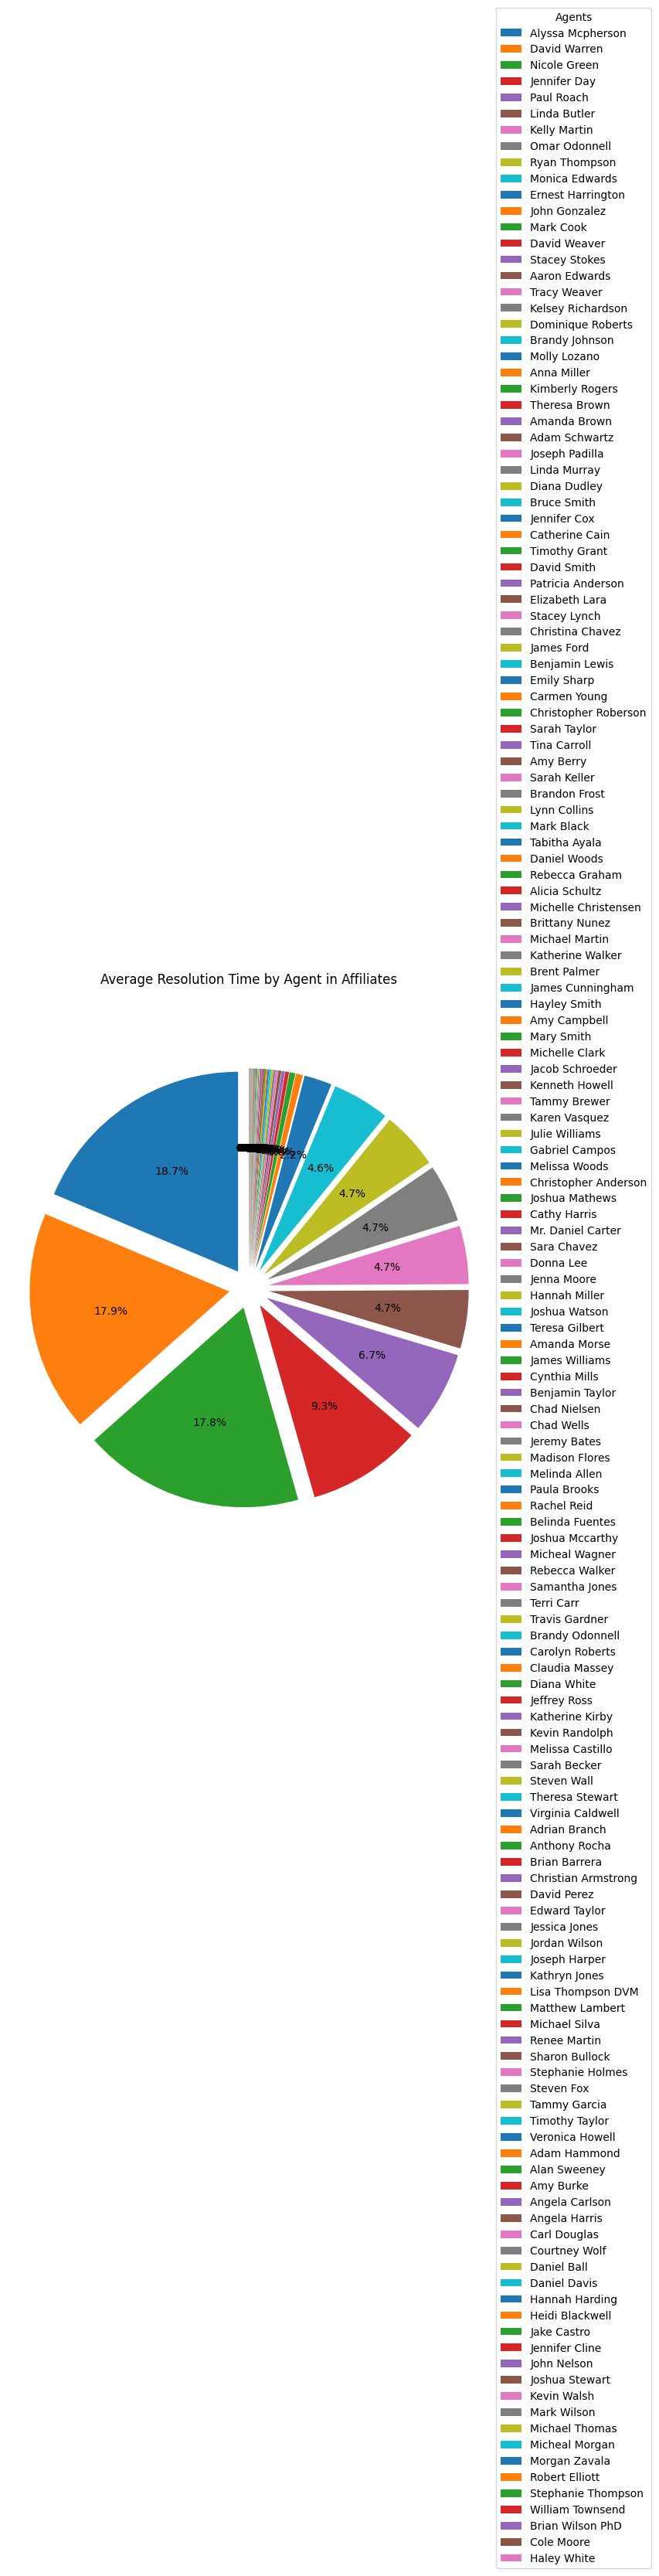

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for category, agents in ordered_agents_by_category.items():
    agent_names = [agent[0] for agent in agents]
    avg_times = [agent[1] for agent in agents]
    # Create a pie chart for average resolution times
    plt.figure(figsize=(10, 10))

    # Use explode to separate the slices for better visibility
    explode = [0.1] * len(agent_names)  # Offset all slices
    wedges, texts, autotexts = plt.pie(avg_times, autopct='%1.1f%%', startangle=90, explode=explode)

    plt.title(f'Average Resolution Time by Agent in {category}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    # Place the legend outside the pie chart
    plt.legend(agent_names, title="Agents", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncol=1)
    plt.subplots_adjust(right=0.75)  # Adjust the plot to make space for the legend
    plt.show()
    break

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
from transformers import BertTokenizer, TFBertModel, pipeline
import tensorflow as tf
from tensorflow.keras import layers, models
import torch

# Load the dataset
data = pd.read_csv('sample_data/Customer_support_data.csv.zip', compression='zip')
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Preprocess the data
data['Customer_Remarks'] = data['Customer_Remarks'].astype(str)

# Check if CSAT_Score is numerical
data['CSAT_Score'] = pd.to_numeric(data['CSAT_Score'], errors='coerce')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['Customer_Remarks'], data['CSAT_Score'], test_size=0.2, random_state=42)

# BERT Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 512  # Maximum sequence length for BERT models

def encode_comments(comments):
    return tokenizer(comments.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = encode_comments(X_train)
test_encodings = encode_comments(X_test)

# Build the LSTM Model for regression on CSAT score
def create_lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128, input_length=max_length))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))  # Single output for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

lstm_model = create_lstm_model()
lstm_model.fit(train_encodings['input_ids'], y_train, epochs=3, batch_size=32)

# Evaluate the model
y_pred_lstm = lstm_model.predict(test_encodings['input_ids'])
print("LSTM MAE:", mean_absolute_error(y_test, y_pred_lstm))

# Check if GPU is available and assign the pipeline to run on GPU if possible
device = 0 if torch.cuda.is_available() else -1  # device=0 uses GPU, -1 uses CPU

# Initialize the sentiment analysis model using Hugging Face pipeline with GPU
sentiment_pipeline = pipeline("sentiment-analysis", device=device)

# Function to get sentiment for customer remarks
def get_sentiment(remark):
    return sentiment_pipeline(remark[:max_length])  # Truncate the text if it's too long for the model

# Apply sentiment analysis on Customer Remarks
data['Sentiment_Score'] = data['Customer_Remarks'].apply(lambda x: get_sentiment(x)[0]['score'])

# Calculate agent performance metrics based on CSAT scores and sentiment
agent_performance_df = data.groupby('Agent_name').agg({
    'CSAT_Score': 'mean',
    'Sentiment_Score': 'mean'
}).reset_index()


Index(['Unique_id', 'channel_name', 'category', 'Sub-category',
       'Customer_Remarks', 'Order_id', 'order_date_time', 'Issue_reported_at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure_Bucket', 'Agent_Shift',
       'CSAT_Score'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2148/2148 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - loss: 2.2453 - mae: 1.1165
Epoch 2/3
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 1.9235 - mae: 1.0551
Epoch 3/3
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 1.8922 - mae: 1.0456
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


LSTM MAE: 1.0201929229724784


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyError: "['Unique_ID'] not in index"

In [19]:
# Calculate incentives based on sentiment scores and agent performance
def calculate_incentives(data, performance_scores):
    data['Incentive'] = data['Sentiment_Score'] * performance_scores
    return data

# Example performance scores (can be derived from other metrics)
performance_scores = np.random.rand(len(agent_performance_df))  # Placeholder for actual performance scores
incentives = calculate_incentives(agent_performance_df, performance_scores)

# Display results
print("Agent Performance Metrics:")
print(agent_performance_df)

print("\nIncentives for Agents:")
print(incentives.head())

Agent Performance Metrics:
            Agent_name  CSAT_Score  Sentiment_Score  Incentive
0        Aaron Edwards    4.397849         0.966071   0.795615
1         Aaron Romero    3.949153         0.966481   0.702975
2     Abigail Gonzalez    4.080000         0.972831   0.514068
3         Adam Barnett    4.339286         0.971105   0.249287
4         Adam Hammond    4.733333         0.973592   0.625009
...                ...         ...              ...        ...
1366    Yesenia Bowers    3.960000         0.949181   0.791040
1367   Zachary Collins    3.533333         0.965514   0.931852
1368      Zachary Ford    3.870968         0.956548   0.233334
1369     Zachary Reyes    4.145455         0.966438   0.567274
1370   Zachary Simpson    4.156250         0.956785   0.266168

[1371 rows x 4 columns]

Incentives for Agents:
         Agent_name  CSAT_Score  Sentiment_Score  Incentive
0     Aaron Edwards    4.397849         0.966071   0.795615
1      Aaron Romero    3.949153         0.966481

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers, models

# Set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load the dataset
data = pd.read_csv('sample_data/Customer_support_data.csv.zip', compression='zip')
data.columns = data.columns.str.replace(' ', '_')

# Preprocess the data
data['Customer_Remarks'] = data['Customer_Remarks'].astype(str)

# Check if CSAT_Score is numerical
data['CSAT_Score'] = pd.to_numeric(data['CSAT_Score'], errors='coerce')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['Customer_Remarks'], data['CSAT_Score'], test_size=0.2, random_state=42)

# BERT Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 64  # Reduced max length to save memory

def encode_comments(comments):
    return tokenizer(comments.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = encode_comments(X_train)
test_encodings = encode_comments(X_test)

# Define BERT Model
def create_bert_model():
    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_length,), dtype=tf.int32)

    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_output = outputs[1]  # Get the CLS token output
    dense = layers.Dense(1, activation='relu', dtype='float32')(cls_output)  # Use float32 for the dense layer
    output = layers.Dense(1, activation='linear', dtype='float32')(dense)  # Single output for regression

    model = models.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Fit the model with Gradient Accumulation
def train_model(model, encodings, y_train, batch_size=8, accumulation_steps=4):
    num_batches = len(y_train) // batch_size
    for epoch in range(1):  # Change to desired number of epochs
        print(f"Epoch {epoch + 1}/{1}")
        for i in range(num_batches):
            with tf.GradientTape() as tape:
                for j in range(accumulation_steps):
                    start_idx = i * batch_size + j * batch_size // accumulation_steps
                    end_idx = start_idx + batch_size // accumulation_steps

                    if end_idx > len(y_train):  # Avoid out of bounds
                        break

                    batch_input_ids = encodings['input_ids'][start_idx:end_idx]
                    batch_attention_mask = encodings['attention_mask'][start_idx:end_idx]
                    batch_labels = y_train[start_idx:end_idx]

                    # Forward pass
                    predictions = model([batch_input_ids, batch_attention_mask], training=True)
                    loss = tf.keras.losses.mean_squared_error(batch_labels, predictions)

            # Calculate gradients and apply them
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# Create and train the BERT model
bert_model = create_bert_model()
train_model(bert_model, train_encodings, y_train)

# Evaluate the BERT model
y_pred_bert = bert_model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
mae = mean_absolute_error(y_test, y_pred_bert.flatten())
print("BERT MAE Report:")
print("Mean Absolute Error:", mae)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

ValueError: Exception encountered when calling layer 'tf_bert_model_11' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tf_bert_model_11' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 64), dtype=int32, sparse=None, name=keras_tensor_30>
  • attention_mask=<KerasTensor shape=(None, 64), dtype=int32, sparse=None, name=keras_tensor_31>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False